In [1]:
!pip install yfinance
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.3 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import datetime
import tensorflow as tf
import xgboost as xgb
import warnings


from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_validate

from numpy import mean, std, sqrt
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima import auto_arima
from datetime import datetime

time_start = datetime.now()

In [3]:
## Setting up the start and end date
start_date = '2003-01-01'
end_date = '2023-11-04'

## Data Preprocessing

In [4]:
# Extract market data of currency symbol
currency = 'GBPINR'
data = yf.download(currency+'=X', start=start_date, end=end_date)

data = data.reset_index()

[*********************100%%**********************]  1 of 1 completed


In [5]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4528.000000,4528.000000,4528.000000,4528.000000,4528.000000,4528.0
mean,88.659436,89.095247,88.213626,88.659930,88.659930,0.0
std,10.081208,10.024791,10.129804,10.046470,10.046470,0.0
min,7.095400,65.987000,7.095400,65.336998,65.336998,0.0
25%,81.482750,81.890749,81.073748,81.468000,81.468000,0.0
50%,88.456997,88.853001,87.972000,88.492500,88.492500,0.0
75%,98.118994,98.503750,97.591551,98.148012,98.148012,0.0
max,107.702225,107.948662,107.523720,107.702225,107.702225,0.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4528 entries, 0 to 4527
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4528 non-null   datetime64[ns]
 1   Open       4528 non-null   float64       
 2   High       4528 non-null   float64       
 3   Low        4528 non-null   float64       
 4   Close      4528 non-null   float64       
 5   Adj Close  4528 non-null   float64       
 6   Volume     4528 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 247.8 KB


## Data Visualization

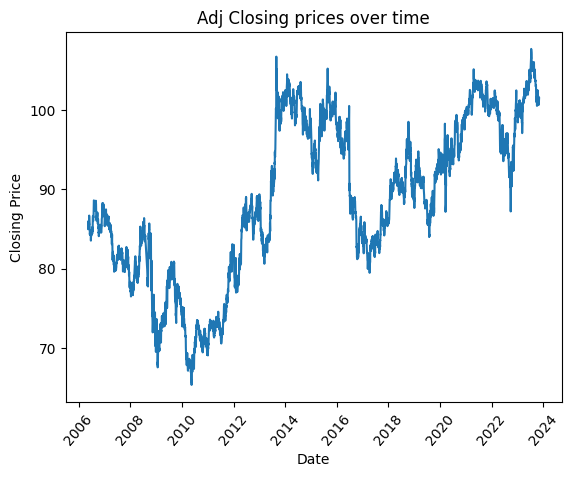

In [8]:
# Plotting the Adj closing prices
plt.plot(data['Date'] ,data['Adj Close'])
plt.title("Adj Closing prices over time")
plt.xlabel("Date")
plt.ylabel("Closing Price")

plt.xticks(rotation=50)
plt.savefig('GBPINR Adj closing price')

plt.show()

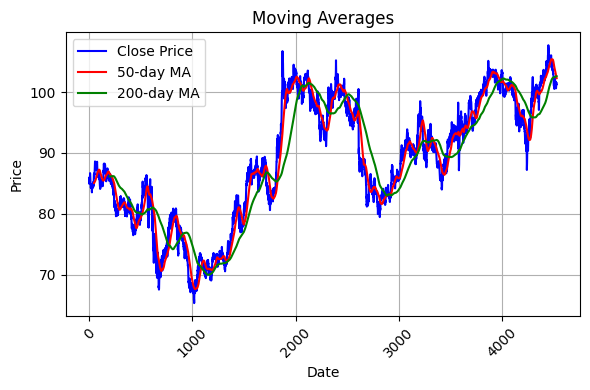

In [9]:
plt.figure(figsize=(6,4))
plt.plot(data.index, data["Adj Close"], label="Close Price", color='b')
plt.plot(data.index, data["Adj Close"].rolling(window=50).mean(), label="50-day MA", color='r')
plt.plot(data.index, data["Adj Close"].rolling(window=200).mean(), label="200-day MA", color='g')
plt.title("Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

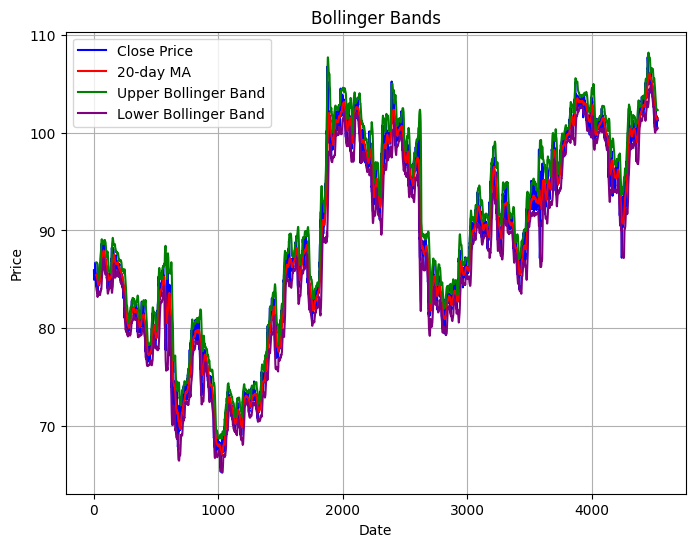

In [10]:
data['20MA'] = data['Adj Close'].rolling(window=20).mean()
data['Upper'] = data['20MA'] + 2 * data['Adj Close'].rolling(window=20).std()
data['Lower'] = data['20MA'] - 2 * data['Adj Close'].rolling(window=20).std()
plt.figure(figsize=(8, 6))
plt.plot(data.index, data['Adj Close'], label='Close Price', color='blue')
plt.plot(data.index, data['20MA'], label='20-day MA', color='red')
plt.plot(data.index, data['Upper'], label='Upper Bollinger Band', color='green')
plt.plot(data.index, data['Lower'], label='Lower Bollinger Band', color='purple')
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()


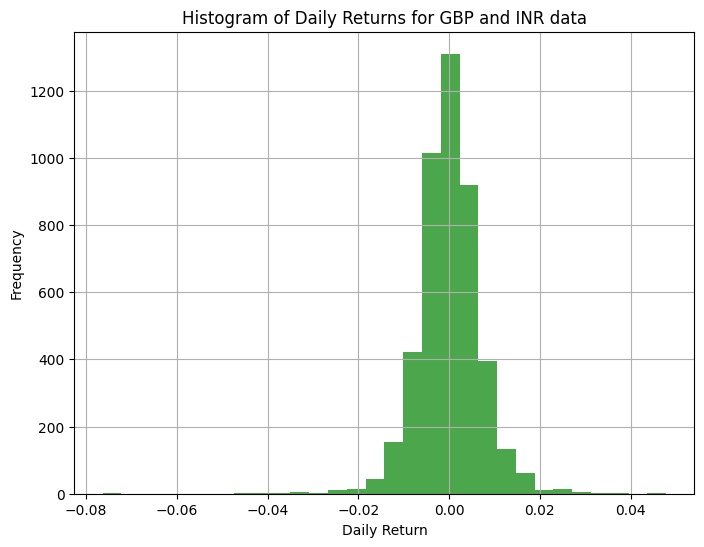

In [11]:
data['Daily Return'] = data['Adj Close'].pct_change()
plt.figure(figsize=(8, 6))
plt.hist(data['Daily Return'].dropna(), bins=30, color='green', alpha=0.7)
plt.title('Histogram of Daily Returns for GBP and INR data')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)

## Splitting of data

In [12]:
# Defining dataset for training, test and validation
feature_data_set = data

train_data_size = int(len(feature_data_set) * 0.80)  ## 80% dataset for training ##
test_data_size = int(len(feature_data_set) * 0.10)   ## 10% dataset for training ##
val_data_size = len(feature_data_set) - train_data_size - test_data_size  ## Validation dataset ##

# Split the data into training, testing, and validation sets
train_data = feature_data_set.iloc[:train_data_size]
validation_data = feature_data_set.iloc[train_data_size: train_data_size + test_data_size]
test_data = feature_data_set.iloc[train_data_size + val_data_size:]

# Print the shapes of the split sets
print(train_data.shape, validation_data.shape, test_data.shape)

(3622, 11) (452, 11) (452, 11)


In [13]:
train_filter_data = train_data.filter(['Close'])
train_data_set = train_filter_data.values

test__filter_data = test_data.filter(['Close'])
test_data_set = test__filter_data.values

validation_filter_data = validation_data.filter(['Close'])
validation_data_set = validation_filter_data.values

train_data_set.shape, test_data_set.shape, validation_data_set.shape

((3622, 1), (452, 1), (452, 1))

In [14]:
## scaling of data
scaler = MinMaxScaler()

Scaled_train_data_set = scaler.fit_transform(train_data_set)
Scaled_val_data_set = scaler.fit_transform(validation_data_set)
Scaled_test_data_set = scaler.fit_transform(test_data_set)

In [15]:
## data spliting into x and y train
X_train = []
y_train = []

step_index = 30

for index in range(len(train_data) - step_index):
    X_train.append(Scaled_train_data_set[index:index + step_index, 0])
    y_train.append(Scaled_train_data_set[step_index + index, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Convert to NumPy array
X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape the input data to match deep learning models
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape(y_train.shape[0],1)

# Print the reshaped data
print(X_train.shape , y_train.shape)

(3592, 30, 1) (3592, 1)


In [16]:
## data spliting into x and y validate
X_Val = []
y_Val = []

for index in range(len(validation_data)-step_index):
    X_Val.append(Scaled_val_data_set[index : index + step_index, 0])
    y_Val.append(Scaled_val_data_set[step_index + index, 0])

X_Val, y_Val = np.array(X_Val), np.array(y_Val)

# Covert to NumPy array
X_Val = np.array(X_Val)
y_Val = np.array(y_Val)

# Reshaped input data to match with deep learning model
y_Val = y_Val.reshape(y_Val.shape[0] , 1)
X_Val = np.reshape(X_Val, (X_Val.shape[0], X_Val.shape[1], 1))

# Print the reshaped data
print(X_Val.shape, y_Val.shape)

(422, 30, 1) (422, 1)


In [17]:
## data spliting into x and y test
X_test = []
y_test = []

for index in range(len(test_data) - step_index):
    X_test.append(Scaled_test_data_set[index : index + step_index, 0])
    y_test.append(Scaled_test_data_set[step_index + index, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Convert to NumPy array
X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape the input data to match the LSTM input shape [samples, timesteps, features]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test=y_test.reshape(y_test.shape[0],1)

# Print the reshaped data
print(X_test.shape, y_test.shape)

(422, 30, 1) (422, 1)


## common function

In [18]:
# function for mean square error
def mse_func(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) ** 2)

In [19]:
# function for root mean square error
def rmse_func(y_true, y_pred):
    rmse_val = math.sqrt(mean_squared_error(y_true, y_pred))
    return rmse_val

In [20]:
# function for mean absolute percentage error
def mape_func(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**GRU Model Fitting**

Epoch 1/30
101/101 [==============================] - 13s 62ms/step - loss: 0.0334 - val_loss: 0.0014
Epoch 2/30
101/101 [==============================] - 5s 47ms/step - loss: 9.7399e-04 - val_loss: 0.0011
Epoch 3/30
101/101 [==============================] - 5s 48ms/step - loss: 7.7405e-04 - val_loss: 9.3661e-04
Epoch 4/30
101/101 [==============================] - 5s 53ms/step - loss: 6.9737e-04 - val_loss: 9.5257e-04
Epoch 5/30
101/101 [==============================] - 5s 45ms/step - loss: 6.9678e-04 - val_loss: 8.6960e-04
Epoch 6/30
101/101 [==============================] - 5s 53ms/step - loss: 5.5063e-04 - val_loss: 7.7791e-04
Epoch 7/30
101/101 [==============================] - 5s 49ms/step - loss: 4.9048e-04 - val_loss: 7.0395e-04
Epoch 8/30
101/101 [==============================] - 4s 44ms/step - loss: 4.8068e-04 - val_loss: 0.0014
Epoch 9/30
101/101 [==============================] - 6s 57ms/step - loss: 4.7866e-04 - val_loss: 5.3829e-04
Epoch 10/30
101/101 [=============

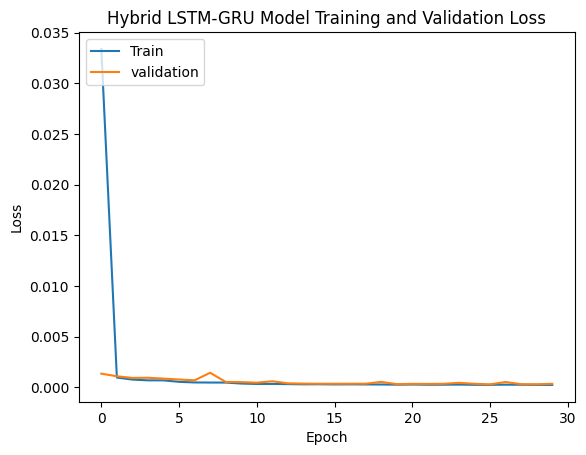

In [21]:
model_hybrid_gru_lstm = Sequential()

model_hybrid_gru_lstm.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=(step_index, 1)))
model_hybrid_gru_lstm.add(GRU(units=64, activation='relu', return_sequences=False))
model_hybrid_gru_lstm.add(Dense(units=1))

model_hybrid_gru_lstm.compile(optimizer='adam', loss='mean_squared_error')

GRU_LSTM_Hybrid_model = model_hybrid_gru_lstm.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)

plt.plot(GRU_LSTM_Hybrid_model.history['loss'])
plt.plot(GRU_LSTM_Hybrid_model.history['val_loss'])

plt.title('Hybrid LSTM-GRU Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.savefig('Hybrid LSTM-GRU Model-Loss.png' )
plt.show()

In [22]:
hybrid_predictions = model_hybrid_gru_lstm.predict(X_Val)

hybrid_predictions_scale_original = scaler.inverse_transform(hybrid_predictions)

y_Val_scale_original = scaler.inverse_transform(y_Val)

14/14 [==============================] - 1s 36ms/step


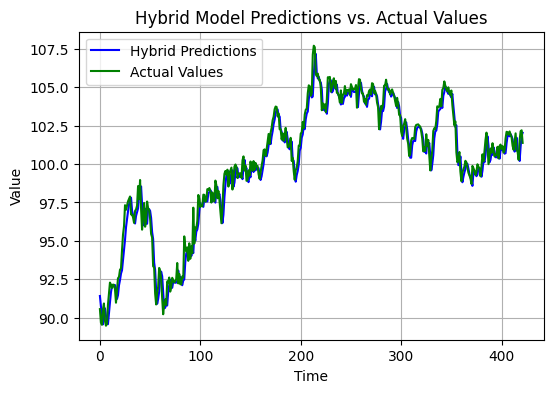

In [23]:
x = range(len(hybrid_predictions_scale_original))

plt.figure(figsize=(6,4))
plt.plot(x, hybrid_predictions_scale_original, label='Hybrid Predictions', color='blue')
plt.plot(x, y_Val_scale_original, label='Actual Values', color='green')

plt.title('Hybrid Model Predictions vs. Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [24]:
mape_val = mape_func(y_Val_scale_original, hybrid_predictions_scale_original)

mse_val = mse_func(y_Val_scale_original, hybrid_predictions_scale_original)

rmse_val = rmse_func(y_Val_scale_original, hybrid_predictions_scale_original)

print('Hybrid model performance during validation phase')
print("Hybrid_RMSE:", rmse_val)
print("Hybrid_MSE:", mse_val)
print("Hybrid_MAPE:", mape_val)

Hybrid model performance during validation phase
Hybrid_RMSE: 0.7289115630592337
Hybrid_MSE: 0.5313120667614551
Hybrid_MAPE: 0.5680034351769148


**GRU LSTM Model Testing**

In [25]:
hybrid_predictions = model_hybrid_gru_lstm.predict(X_test)

predictions_scale_original = scaler.inverse_transform(hybrid_predictions)

y_test_scale_original = scaler.inverse_transform(y_test)

14/14 [==============================] - 0s 12ms/step


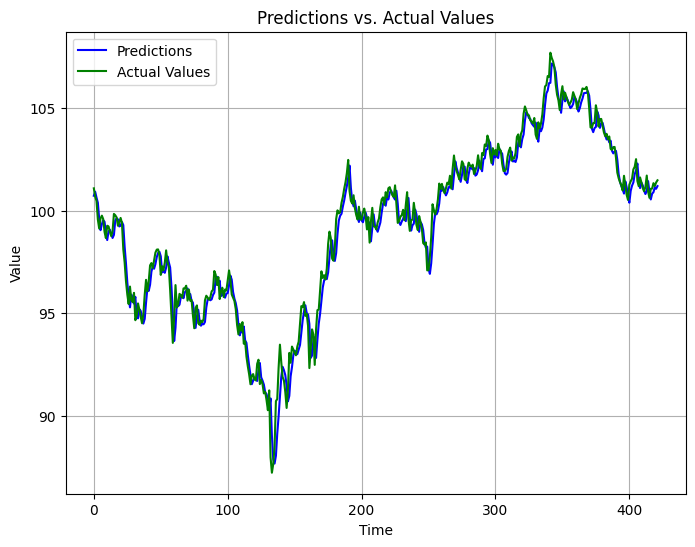

In [26]:
x = range(len(predictions_scale_original))

plt.figure(figsize=(8, 6))
plt.plot(x, predictions_scale_original, label='Predictions', color='blue')
plt.plot(x, y_test_scale_original, label='Actual Values', color='green')

plt.title('Predictions vs. Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

## model performance on testing data

In [27]:
mse_test = mse_func(y_test_scale_original, predictions_scale_original)

rmse_test = rmse_func(y_test_scale_original, predictions_scale_original)

mape_test = mape_func(y_test_scale_original, predictions_scale_original)

print('Hybrid model performance during testing phase')

print("Hybrid MSE:", mse_test)

print("Hybrid RMSE:", rmse_test)

print("Hybrid MAPE:", mape_test)

Hybrid model performance during testing phase
Hybrid MSE: 0.4361670881387573
Hybrid RMSE: 0.660429472494041
Hybrid MAPE: 0.5053343887656359


**Hybrid GRU Model Prediction**

In [ ]:
num_future_days = 14

lastest_date = pd.to_datetime(data['Date'].iat[-1])

# Generate the list of dates for forecast
next_14_days = [lastest_date + datetime.timedelta(days=i) for i in range(1, num_future_days + 1)]

# Print the predicted rates for the next month
for date, price in zip(next_14_days[:14], predictions_scale_original[-14:]):
    print(f"{date.date()}: {price}")

2023-11-01: [102.271935]
2023-11-02: [102.55806]
2023-11-03: [101.90075]
2023-11-04: [101.37866]
2023-11-05: [101.53587]
2023-11-06: [101.474556]
2023-11-07: [101.2235]
2023-11-08: [101.02405]
2023-11-09: [101.12894]
2023-11-10: [101.59985]
2023-11-11: [101.24344]
2023-11-12: [100.80992]
2023-11-13: [100.99306]
2023-11-14: [101.12696]


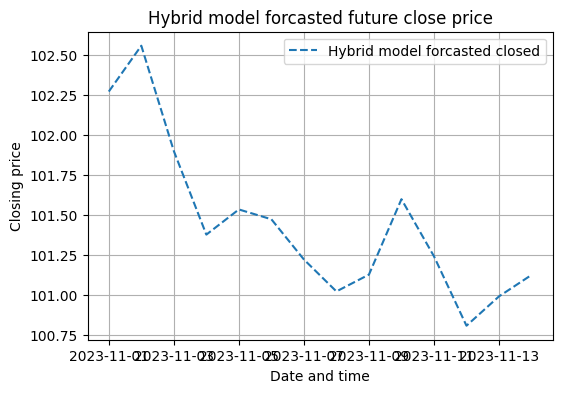

In [ ]:
plt.figure(figsize=(6,4))

plt.plot(next_14_days[:14], predictions_scale_original[-14:], label='Hybrid model forcasted closed', linestyle='dashed')

plt.xlabel('Date and time')
plt.ylabel('Closing price')
plt.title('Hybrid model forcasted future close price')
plt.legend()
plt.grid(True)
plt.savefig('hybrid gbp to inr')
plt.show()

**CNN model**

**Model Fitting**

In [28]:
# Define the CNN model
cnn_model = Sequential()

# Add a 1D convolutional layer with 32 filters, kernel size 3, and ReLU activation
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))

# Add a max pooling layer with pool size 2
cnn_model.add(MaxPooling1D(pool_size=2))

# Flatten the output from the previous layer
cnn_model.add(Flatten())

# Add a fully connected dense layer with 64 units and ReLU activation
cnn_model.add(Dense(64, activation='relu'))

# Add a final dense layer with 1 unit and linear activation for regression
cnn_model.add(Dense(1, activation='linear'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
cnn_model.summary()

#compile the model
cnn_model.compile(optimizer='adam', loss='mean_squared_error')

#train the model
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=16, epochs=20)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                28736     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 28929 (113.00 KB)
Trainable params: 28929 (113.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________

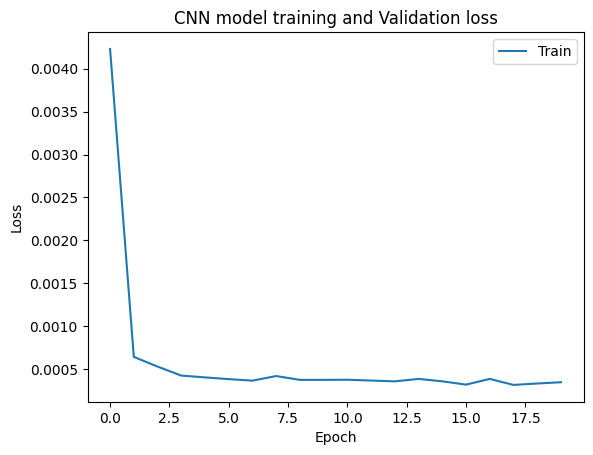

In [29]:
plt.plot(cnn_model_history.history['loss'])

plt.title('CNN model training and Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Train', 'validation'], loc='best')
plt.savefig('CNN_model_loss.png' )
plt.show()

In [30]:
history_test = cnn_model.fit(X_test, y_test, batch_size=16, epochs=30)

Epoch 1/30
27/27 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 2/30
27/27 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 3/30
27/27 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 4/30
27/27 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 5/30
27/27 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 6/30
27/27 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 7/30
27/27 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 8/30
27/27 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 9/30
27/27 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 10/30
27/27 [==============================] - 0s 3ms/step - loss: 9.3963e-04
Epoch 11/30
27/27 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 12/30
27/27 [==============================] - 0s 3ms/step - loss: 9.8952e-04
Epoch 13/30
27/27 [======================

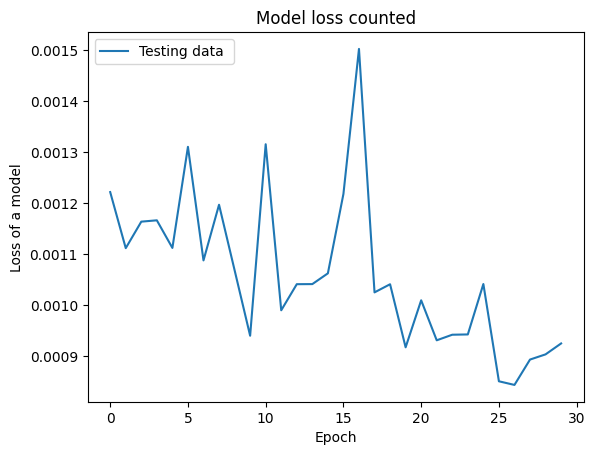

In [31]:
#show model loss
plt.plot(history_test.history['loss'])
plt.title('Model loss counted')
plt.ylabel('Loss of a model')
plt.xlabel('Epoch')
plt.legend(['Testing data '], loc='upper left')
plt.show()

In [32]:
predict = cnn_model.predict(X_test)

predict_original_scale = predict * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

y_test_original = y_test * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

14/14 [==============================] - 0s 3ms/step


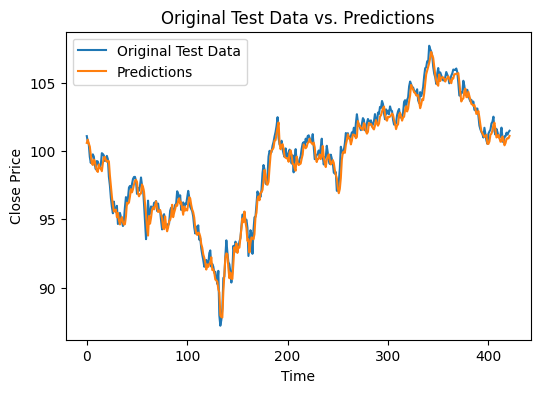

In [33]:
plt.figure(figsize=(6, 4))

# Plot original test data
plt.plot(y_test_original, label='Original Test Data')

# Plot predicted data
plt.plot(predict_original_scale, label='Predictions')

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Original Test Data vs. Predictions')
plt.legend()
plt.savefig('Exchange rate test and actual prediction')
plt.show()

In [34]:
rmse_val = rmse_func(y_test_original, predict_original_scale)
mape_val = mape_func(y_test_original, predict_original_scale)
mse_val = mse_func(y_test_original, predict_original_scale)

print('model performance')
print("RMSE:", rmse_val)
print("MAPE:", mape_val)
print("MSE:", mse_val)

model performance
RMSE: 0.6235874872983522
MAPE: 0.49513468283578066
MSE: 0.3888613543150726


In [35]:
history_val = cnn_model.fit(X_Val, y_Val, batch_size=16, epochs=30)

Epoch 1/30
27/27 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 2/30
27/27 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 3/30
27/27 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 4/30
27/27 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 5/30
27/27 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 6/30
27/27 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 7/30
27/27 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 8/30
27/27 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 9/30
27/27 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 10/30
27/27 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 11/30
27/27 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 12/30
27/27 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 13/30
27/27 [==============================

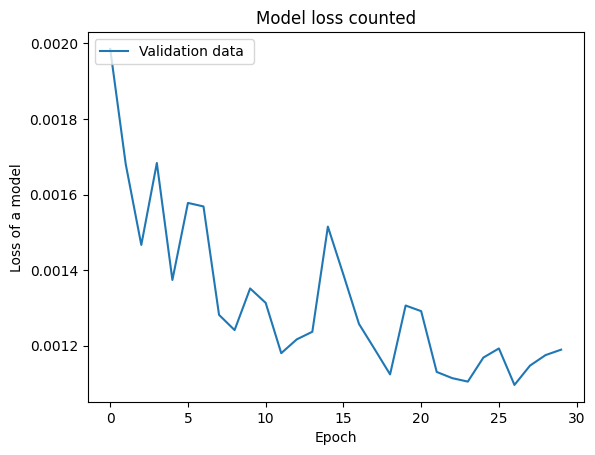

In [36]:
#show model loss
plt.plot(history_val.history['loss'])
plt.title('Model loss counted')
plt.ylabel('Loss of a model')
plt.xlabel('Epoch')
plt.legend(['Validation data '], loc='upper left')
plt.show()

In [37]:
predict_val = cnn_model.predict(X_Val)

predict_original_val = predict_val * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

y_Val_original = y_Val * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

14/14 [==============================] - 0s 6ms/step


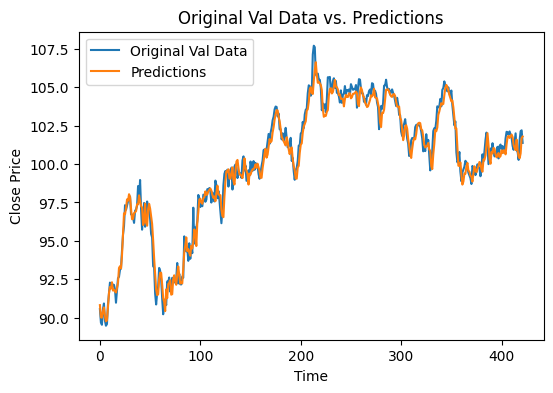

In [38]:
plt.figure(figsize=(6, 4))

# Plot original test data
plt.plot(y_Val_original, label='Original Val Data')

# Plot predicted data
plt.plot(predict_original_val, label='Predictions')

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Original Val Data vs. Predictions')
plt.legend()
plt.savefig('Exchange rate val and actual prediction')
plt.show()

In [39]:
rmse_val = rmse_func(y_Val_original, predict_original_val)
mse_val = mse_func(y_Val_original, predict_original_val)
mape_val = mape_func(y_Val_original, predict_original_val)

print('model performance')
print("RMSE:", rmse_val)
print("MSE:", mse_val)
print("MAPE:", mape_val)

model performance
RMSE: 0.676117344552645
MSE: 0.45713466360492017
MAPE: 0.5241526752284815


In [ ]:
num_future_days = 14

lastest_date = pd.to_datetime(data['Date'].iat[-1])

# Generate the list of dates for forecast
next_14_days = [lastest_date + datetime.timedelta(days=i) for i in range(1, num_future_days + 1)]

# Print the predicted rates for the next month
for date, price in zip(next_14_days[:14], predict_original_scale[-14:]):
    print(f"{date.date()}: {price}")

2023-11-01: [102.475136]
2023-11-02: [102.75199]
2023-11-03: [102.32863]
2023-11-04: [101.622154]
2023-11-05: [101.965836]
2023-11-06: [101.823875]
2023-11-07: [101.61198]
2023-11-08: [101.25067]
2023-11-09: [101.35397]
2023-11-10: [101.862976]
2023-11-11: [101.55221]
2023-11-12: [101.209885]
2023-11-13: [101.39296]
2023-11-14: [101.55608]


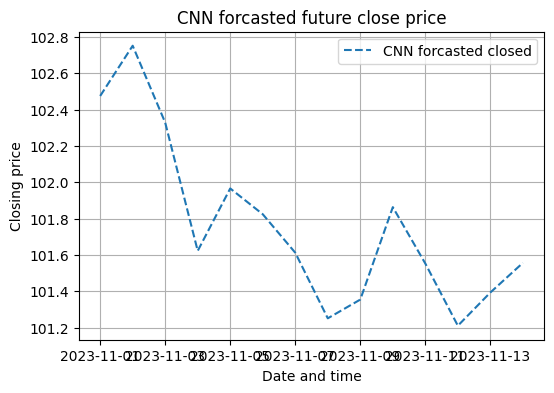

In [ ]:
plt.figure(figsize=(6,4))

plt.plot(next_14_days[:14], predict_original_scale[-14:], label='CNN forcasted closed', linestyle='dashed')

plt.xlabel('Date and time')
plt.ylabel('Closing price')
plt.title('CNN forcasted future close price')
plt.legend()
plt.grid(True)
plt.savefig('CNN forecasted value')
plt.show()

**ARIMA Model**

**Data Preparatation**

In [40]:
from statsmodels.tsa.arima.model import ARIMA

# Define the sizes of training, testing, and validation sets
train_size = int(len(data) * 0.90)  # 90% of the data for training
test_size = int(len(data) * 0.05)   # 5% of the data for testing
val_size = len(data) - train_size - test_size  # Remaining for validation

# Split the data into training, testing, and validation sets
train = data.iloc[:train_size]
validation = data.iloc[train_size: train_size + test_size]
test = data.iloc[train_size + val_size:]

# Print the shapes of the split sets
print(train.shape, test.shape, validation.shape)

(4075, 11) (226, 11) (226, 11)


In [41]:
train_data = train.filter(['Adj Close'])
train_set = train_data.values

test_data = test.filter(['Adj Close'])
test_set = test_data.values

validation_data = validation.filter(['Adj Close'])
validation_set = validation_data.values

train_set.shape,test_set.shape,validation_set.shape

((4075, 1), (226, 1), (226, 1))

<ipython-input-42-78adb4d6c8ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Date'] = pd.to_datetime(train['Date'])
<ipython-input-42-78adb4d6c8ac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Date'] = pd.to_datetime(test['Date'])
<ipython-input-42-78adb4d6c8ac>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

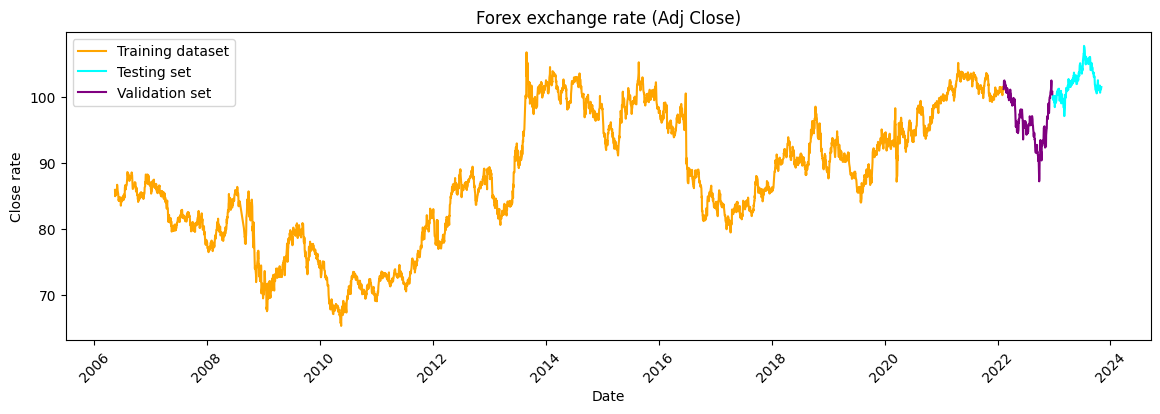

In [42]:
# Assuming you have DataFrames named train, test, and validation with a "Date" column
# Convert the "Date" column to datetime if it's not already
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
validation['Date'] = pd.to_datetime(validation['Date'])

plt.figure(figsize=(14, 4))
plt.plot(train["Date"], train["Adj Close"], color='orange', label='Training dataset')
plt.plot(test["Date"], test["Adj Close"], color='cyan', label='Testing set')
plt.plot(validation["Date"], validation["Adj Close"], color='purple', label='Validation set')

plt.legend()
plt.title('Forex exchange rate (Adj Close)')
plt.xlabel('Date')
plt.ylabel('Close rate')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.savefig('Splitting_of_Data.png')  # Save the plot to a file

plt.show()

**Performing Dickey Fuller Test**

In [43]:
def ad_test_func(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    print("1. ADF: ",dftest[0])
    print("2. P-value:",dftest[1])
    print("3.No of Lags",dftest[2])
    print("4.The number of observations utilised for ADF Calculation of regression and critical values",dftest[3])
    print("5.crtical value:")
    for key, val in dftest[4].items():
        print("\t",key,":",val)

In [44]:
ad_test_func(data["Adj Close"])

1. ADF:  -1.5382371648700186
2. P-value: 0.5145183565519136
3.No of Lags 25
4.The number of observations utilised for ADF Calculation of regression and critical values 4502
5.crtical value:
	 1% : -3.4318033612803673
	 5% : -2.8621822128934764
	 10% : -2.5671118533862534


**Make Stationary data for ARIMA model**

<Axes: >

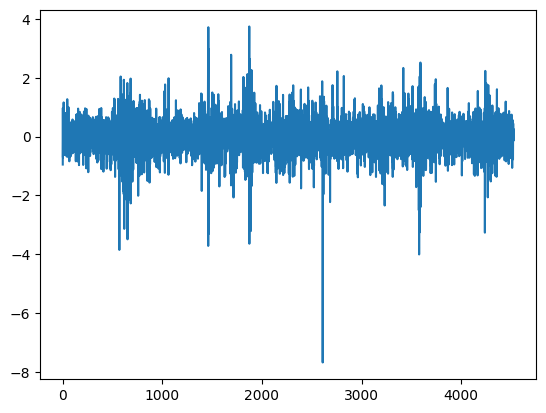

In [45]:
data["Adj Close"].diff(1).dropna().plot()

In [46]:
ad_test_func(data["Adj Close"].diff(1).dropna())

1. ADF:  -13.968434995043424
2. P-value: 4.389607479618602e-26
3.No of Lags 24
4.The number of observations utilised for ADF Calculation of regression and critical values 4502
5.crtical value:
	 1% : -3.4318033612803673
	 5% : -2.8621822128934764
	 10% : -2.5671118533862534


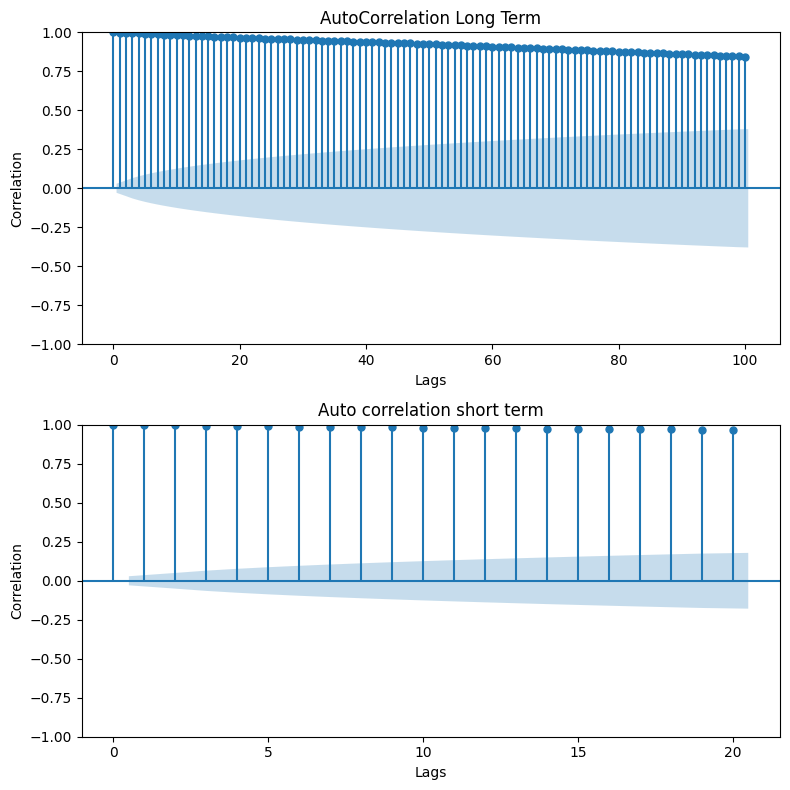

In [47]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))

# Plotting auto-correlation for long term (lags=180)
acf_long_term = plot_acf(data['Adj Close'], lags=100, ax=ax1)
ax1.set_title('AutoCorrelation Long Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')

# Plotting auto-correlation for short term (lags=30)
acf_short_term = plot_acf(data['Adj Close'], lags=20, ax=ax2)
ax2.set_title('Auto correlation short term')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

plt.tight_layout()
plt.savefig('ACF value')

# Displaying the plot
plt.show()

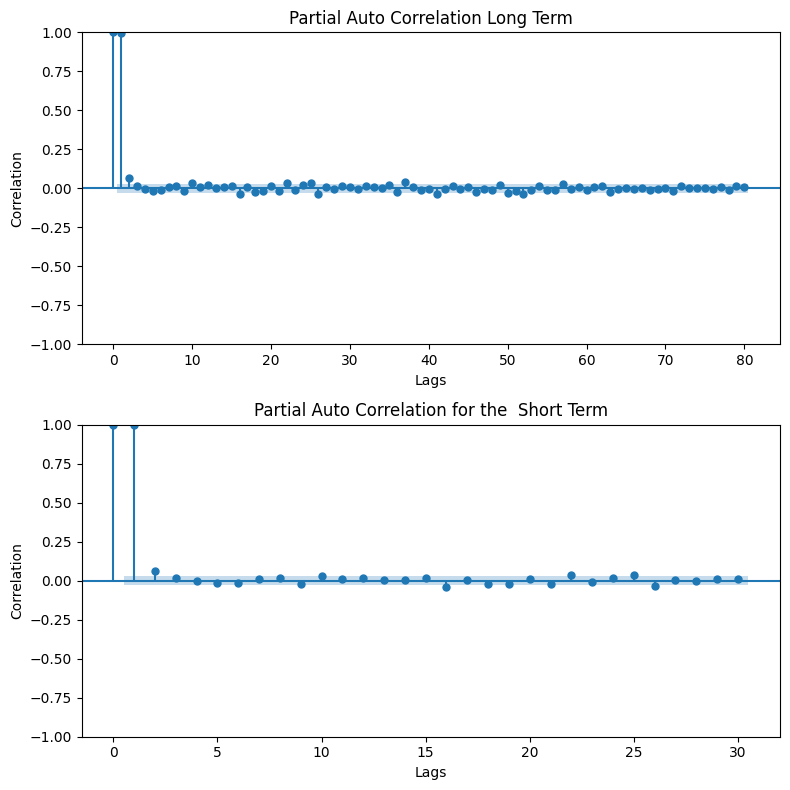

In [48]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))

# Plotting auto-correlation for long term (lags=180)
plot_pacf(data['Adj Close'], lags=80, ax=ax1)
ax1.set_title('Partial Auto Correlation Long Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')

# Plotting auto-correlation for short term (lags=30)
plot_pacf(data['Adj Close'], lags=30, ax=ax2)
ax2.set_title('Partial Auto Correlation for the  Short Term')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

# Adjust subplot spacing
plt.tight_layout()
plt.savefig('PACF')
# Display the plot
plt.show()

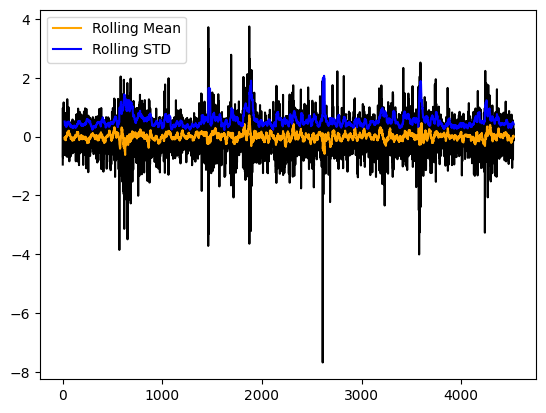

In [49]:
##Differencing
diff_data = data["Adj Close"].diff(1).dropna()

# Plotting the original data
plt.plot(diff_data, c='black')

# Plotting the rolling mean
plt.plot(diff_data.rolling(20).mean(), label='Rolling Mean', c='orange')

# Plotting the rolling standard deviation
plt.plot(diff_data.rolling(20).std(), label='Rolling STD', c='blue')

# Adding legend
plt.legend(prop={'size': 10})

# Displaying the plot
plt.show()

In [50]:
ad_test_func(diff_data)

1. ADF:  -13.968434995043424
2. P-value: 4.389607479618602e-26
3.No of Lags 24
4.The number of observations utilised for ADF Calculation of regression and critical values 4502
5.crtical value:
	 1% : -3.4318033612803673
	 5% : -2.8621822128934764
	 10% : -2.5671118533862534


**ARIMA model after stationary data**

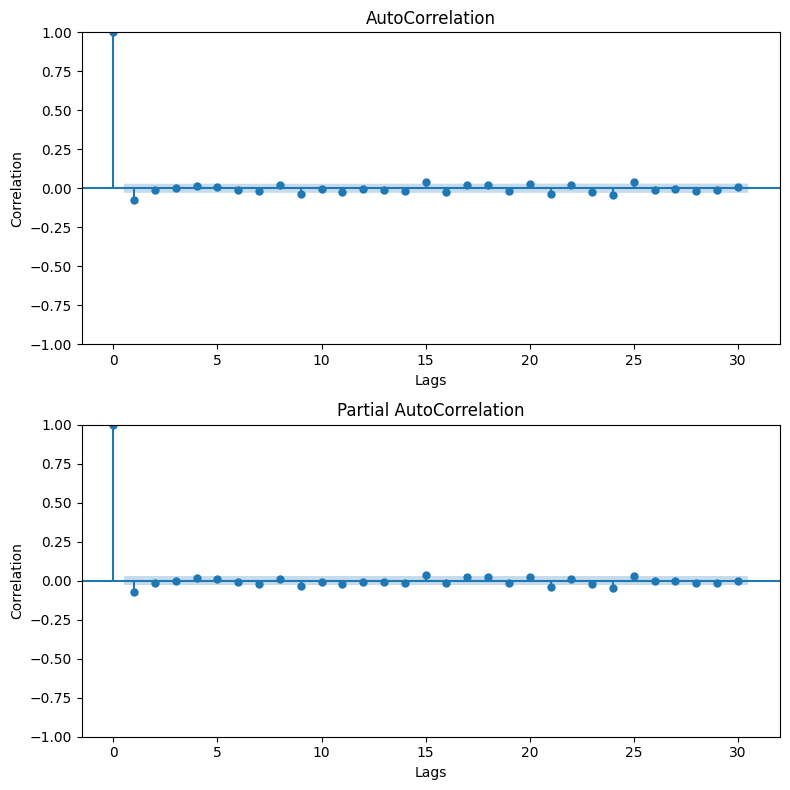

In [51]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))

# Plotting auto-correlation for long term (lags=180)
plot_acf(diff_data, lags=30, ax=ax1)
ax1.set_title('AutoCorrelation')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')

# Plotting auto-correlation for short term (lags=30)
plot_pacf(diff_data, lags=30, ax=ax2)
ax2.set_title('Partial AutoCorrelation')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

# Adjust subplot spacing
plt.tight_layout()

# Display the plot
plt.show()


In [52]:
# Define the sizes of training, testing, and validation sets
diff_train_size = int(len(diff_data) * 0.90)  # 80% of the data for training
diff_test_size = int(len(diff_data) * 0.05)   # 10% of the data for testing
diff_val_size = len(diff_data) - diff_train_size - diff_test_size  # Remaining for validation

# Split the data into training, testing, and validation sets
train_diff = data.iloc[:diff_train_size]
validation_diff = data.iloc[diff_train_size: diff_train_size + diff_test_size]
test_diff = data.iloc[diff_train_size + diff_val_size:]

# Print the shapes of the split sets
print(train_diff.shape, test_diff.shape, validation_diff.shape)

(4074, 11) (227, 11) (226, 11)


In [53]:
train_data_diff = train_diff.filter(['Adj Close'])
train_set_diff = train_data_diff.values

test_data_diff = test_diff.filter(['Adj Close'])
test_set_diff = test_data_diff.values

validation_data_diff = validation_diff.filter(['Adj Close'])
validation_set_diff = validation_data_diff.values

train_set_diff.shape,test_set_diff.shape,validation_set_diff.shape

((4074, 1), (227, 1), (226, 1))

In [54]:
warnings.filterwarnings("ignore")
stepwise_fit = auto_arima(train_diff["Adj Close"], trace=True,suppress_warnings=True, seasonal=False)

print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7486.123, Time=12.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7511.257, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7482.600, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7482.343, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7509.408, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7484.343, Time=3.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7484.343, Time=1.68 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7486.024, Time=2.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7480.528, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7482.534, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7482.528, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7480.782, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=7484.202, Time=0.38 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 21.633 seconds
                    

In [55]:
orders= (0,1,1)

model = ARIMA(train_diff['Adj Close'],order=orders )
model = model.fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 4074
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3738.264
Date:                Fri, 17 Nov 2023   AIC                           7480.528
Time:                        00:57:12   BIC                           7493.152
Sample:                             0   HQIC                          7484.999
                               - 4074                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0872      0.008    -11.087      0.000      -0.103      -0.072
sigma2         0.3670      0.003    111.425      0.000       0.361       0.374
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [56]:
validation_diff['Date'] = pd.to_datetime(validation_diff['Date'])
validation_diff.set_index('Date', inplace=True)

validation_diff

test_diff['Date'] = pd.to_datetime(test_diff['Date'])
test_diff.set_index('Date', inplace=True)

test_diff

,Open,High,Low,Close,Adj Close,Volume,20MA,Upper,Lower,Daily Return
Date,,,,,,,,,,
2022-12-22,100.110008,100.457893,99.427406,100.110008,100.110008,0,100.042094,102.666965,97.417224,-0.006331
2022-12-23,99.782021,100.145836,99.587051,99.782021,99.782021,0,100.082619,102.662539,97.502699,-0.003276
2022-12-26,99.661827,100.049599,98.759323,99.563568,99.563568,0,100.128050,102.633026,97.623074,-0.002189
2022-12-27,100.178841,100.247482,99.409897,100.187927,100.187927,0,100.254599,102.473312,98.035886,0.006271
2022-12-28,99.564957,100.366135,99.373634,99.570961,99.570961,0,100.355458,102.210879,98.500036,-0.006158
...,...,...,...,...,...,...,...,...,...,...
2023-10-30,100.835655,101.291039,100.650528,101.073570,101.073570,0,101.321220,102.329979,100.312461,0.000086
2023-10-31,101.267296,101.545219,100.924484,101.338135,101.338135,0,101.350019,102.323858,100.376181,0.002618
2023-11-01,101.195366,101.272331,100.750038,101.195366,101.195366,0,101.383820,102.280100,100.487541,-0.001409


**ARIMA model validation**

In [57]:
# Define the number of forecast steps
num_forecast_steps = len(validation_diff)

# Initialize a list to store the predictions
predictions = []

# Initialize an index for predictions with the same date format
prediction_index = validation_diff.index

# Perform rolling predictions
for i in range(num_forecast_steps):
    # Forecast the next time step
    forecast = model.forecast(steps=1, typ='levels')
    predictions.append(forecast.item())

    # Update the model with the new observed data
    new_observation = validation_diff.iloc[i]['Adj Close']

    # Re-fit the ARIMA model with updated data
    p, d, q = (0, 1, 1)  # Replace with your chosen orders
    model = ARIMA(pd.concat([train_diff['Adj Close'], validation_diff.iloc[:i+1]['Adj Close']]), order=(p, d, q))
    model = model.fit()

# Create a Series with predictions and the original date index
pred_series = pd.Series(predictions, index=prediction_index, name='ARIMA Predictions')

# If you want to compare predictions to actual validation data
predicted_arima = pd.concat([validation_diff['Adj Close'], pred_series], axis=1)

print(predicted_arima)


             Adj Close  ARIMA Predictions
Date                                     
2022-02-08  101.045326         101.022793
2022-02-09  101.185410         101.043361
2022-02-10  101.260559         101.173015
2022-02-11  102.397301         101.252921
2022-02-14  102.472862         102.297546
...                ...                ...
2022-12-14  101.836731         101.360437
2022-12-15  102.472588         101.800119
2022-12-16  100.948441         102.421036
2022-12-19  100.477226         101.062272
2022-12-20  100.344864         100.522104

[226 rows x 2 columns]


In [58]:
rmse_val = rmse_func(predicted_arima['Adj Close'], predicted_arima['ARIMA Predictions'])

mape_val = mape_func(predicted_arima['Adj Close'], predicted_arima['ARIMA Predictions'])

mse_val = mse_func(predicted_arima['Adj Close'], predicted_arima['ARIMA Predictions'])

print("RMSE:", rmse_val)

print("MAPE:", mape_val)

print("MSE:", mse_val)

RMSE: 0.6793054697662361
MAPE: 0.5327545665140866
MSE: 0.4614559212543267


**Arima Model Testing**

In [59]:
model = ARIMA(train_diff['Adj Close'],order= orders)
model = model.fit()

pred = model.forecast(steps=len(validation_diff) ,typ='levels')
pred = pred.rename('ARIMA Predictions')
pred.index = validation_diff.index[:len(pred)]
print(pred.index)

model = pd.concat([train_diff['Adj Close'],validation_diff['Adj Close'],pred])
model

DatetimeIndex(['2022-02-08', '2022-02-09', '2022-02-10', '2022-02-11',
               '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
               '2022-02-18', '2022-02-21',
               ...
               '2022-12-07', '2022-12-08', '2022-12-09', '2022-12-12',
               '2022-12-13', '2022-12-14', '2022-12-15', '2022-12-16',
               '2022-12-19', '2022-12-20'],
              dtype='datetime64[ns]', name='Date', length=226, freq=None)


0                       85.910004
1                       84.959999
2                       85.930000
3                       85.220001
4                       85.379997
                          ...    
2022-12-14 00:00:00    101.022793
2022-12-15 00:00:00    101.022793
2022-12-16 00:00:00    101.022793
2022-12-19 00:00:00    101.022793
2022-12-20 00:00:00    101.022793
Length: 4526, dtype: float64

In [60]:
model = ARIMA(pd.concat([train_diff['Adj Close'],validation_diff['Adj Close']]),order=orders)
model = model.fit()
predictions=[]

for i in range(len(test_diff)):
    # Forecast the next time step
    forecast = model.forecast()
    predictions.append(forecast.item())
    forecast = pd.Series(forecast.item(), index=[test_diff.index[i]])
    #print(forecast)
    model = ARIMA(pd.concat([train_diff['Adj Close'],validation_diff['Adj Close'],forecast]),order=orders)
    model = model.fit()

pred_series = pd.Series(predictions, index=test_diff.index, name='ARIMA Predictions')
predicted_arima = pd.concat([test_diff['Adj Close'], pred_series], axis=1)

print(predicted_arima)

             Adj Close  ARIMA Predictions
Date                                     
2022-12-22  100.110008         100.358459
2022-12-23   99.782021         100.358459
2022-12-26   99.563568         100.358459
2022-12-27  100.187927         100.358459
2022-12-28   99.570961         100.358459
...                ...                ...
2023-10-30  101.073570         100.358459
2023-10-31  101.338135         100.358459
2023-11-01  101.195366         100.358459
2023-11-02  101.373367         100.358459
2023-11-03  101.477783         100.358459

[227 rows x 2 columns]


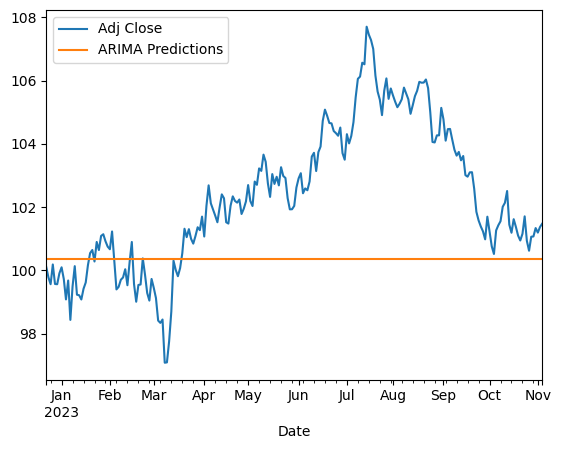

In [61]:
predicted_arima.plot()

plt.savefig('arima prediction')

In [62]:
mape_val = mape_func(predicted_arima['Adj Close'], predicted_arima['ARIMA Predictions'])
mse_val = mse_func(predicted_arima['Adj Close'], predicted_arima['ARIMA Predictions'])
rmse_val = rmse_func(predicted_arima['Adj Close'], predicted_arima['ARIMA Predictions'])

print("MAE:", mape_val)
print("MSE:", mse_val)
print("RMSE:", rmse_val)

MAE: 2.2519917362145354
MSE: 8.638392513590015
RMSE: 2.93911423962901


## Future prediction using ARIMA

In [ ]:
num_future_days = 14

lastest_date = pd.to_datetime(data['Date'].iat[-1])

# Generate the list of dates for forecast
next_14_days = [lastest_date + datetime.timedelta(days=i) for i in range(1, num_future_days + 1)]
# Print the predicted rates for the next month
for date, price in zip(next_14_days[:14], predicted_arima[-14:]):
    print(f"{date.date()}: {price}")

2023-11-02: Adj Close
2023-11-03: ARIMA Predictions


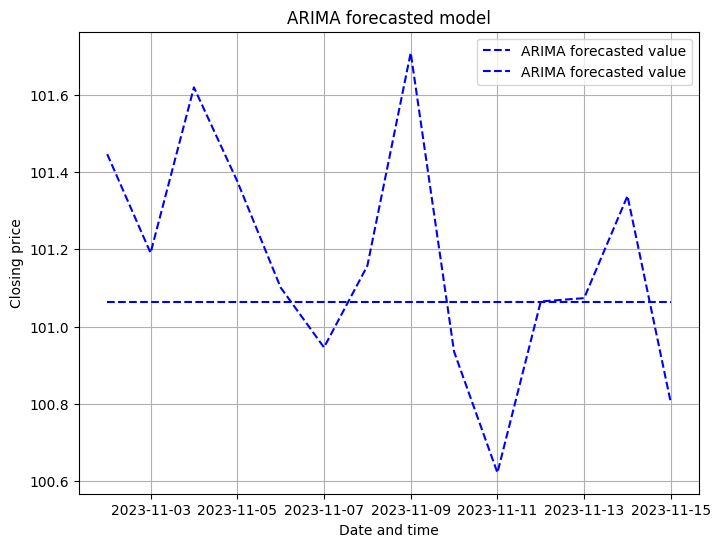

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(next_14_days[:14], predicted_arima[-14:], label='ARIMA forecasted value', linestyle='dashed', color='blue')
plt.xlabel('Date and time')
plt.ylabel('Closing price')
plt.title('ARIMA forecasted model')

plt.legend()
plt.grid(True)
plt.savefig('arima forecasted gbp to inr')
plt.show()